# RFM Segmentation Using Simple and KMeans Method 

**RFM (Recency, Frequency, Monetary)** segmentation is a powerful technique used by marketers to categorize customers based on their recent purchase behavior. This segmentation method divides customers into groups based on how recently they made a purchase (Recency), how often they make purchases (Frequency), and how much they spend (Monetary). By applying simple method and a more sophisticated clustering algorithms such as KMeans to RFM data, marketers can further refine their customer targeting strategies, identify valuable customer segments, and tailor marketing campaigns to maximize engagement and revenue. 

This repository explores the application of simple and KMeans methods to RFM segmentation, showcasing how these techniques can be used to extract actionable insights from customer data.

# 0. Dataset

For this analysis, we will use Online Retail II UCI dataset which you can download from Kaggle <a href="https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci">here.</a> The data contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011. The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

In [345]:
!kaggle datasets download -d dhirajbembade/csv-file -p dataset/

csv-file.zip: Skipping, found more recently modified local copy (use --force to force download)


In [346]:
import zipfile
import os

path = 'dataset/csv-file.zip'
extract_dir = 'dataset/'

with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

extracted_files = os.listdir(extract_dir)
print("Extracted files:", extracted_files)

Extracted files: ['online USA-retail.csv', 'csv-file.zip']


# 1. Data Preparation

In [347]:
import pandas as pd
import numpy as np

In [348]:
df = pd.read_csv('dataset/online USA-retail.csv')
df.head(5)

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom

In [349]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


## 1.1. Check Null Values in All Columns

In [350]:
# null values for Customer ID

invoice_counts = df[df['Customer ID'].isnull()].groupby('Invoice')['Customer ID'].nunique()
invoices_to_check = invoice_counts[invoice_counts >= 1].index

if len(invoices_to_check) == 0:
    df = df[~df['Customer ID'].isnull()]
    print('All null Customer ID can be deleted.')
    print('length after dropping null values:', len(df))
else:
    print('Check these invoices:', invoices_to_check)

All null Customer ID can be deleted.
length after dropping null values: 824364


## 1.2. Check Duplicated Records

In [351]:
df[df.duplicated(keep=False)].sort_values(['Invoice', 'StockCode'])

Invoice StockCode                          Description  Quantity  \
379       489517     21491      SET OF THREE VINTAGE GIFT WRAPS         1   
391       489517     21491      SET OF THREE VINTAGE GIFT WRAPS         1   
365       489517     21821     GLITTER STAR GARLAND WITH BELLS          1   
386       489517     21821     GLITTER STAR GARLAND WITH BELLS          1   
363       489517     21912             VINTAGE SNAKES & LADDERS         1   
...          ...       ...                                  ...       ...   
965610   C574510     22360      GLASS JAR ENGLISH CONFECTIONERY        -1   
986868   C575940     23309  SET OF 60 I LOVE LONDON CAKE CASES        -24   
986869   C575940     23309  SET OF 60 I LOVE LONDON CAKE CASES        -24   
1055441  C580764     22667                RECIPE BOX RETROSPOT        -12   
1055442  C580764     22667                RECIPE BOX RETROSPOT        -12   

                 InvoiceDate  Price  Customer ID         Country  
379      2009-12-01 11:34:00   1.95      16329.0  United Kingdom  
391      2009-12-01 11:34:00   1.95      16329.0  United Kingdom  
365      2009-12-01 11:34:00   3.75      16329.0  United Kingdom  
386      2009-12-01 11:34:00   3.75      16329.0  United Kingdom  
363      2009-12-01 11:34:00   3.75      16329.0  United Kingdom  
...                      ...    ...          ...             ...  
965610   2011-11-04 13:25:00   2.95      15110.0  United Kingdom  
986868   2011-11-13 11:38:00   0.55      17838.0  United Kingdom  
986869   2011-11-13 11:38:00   0.55      17838.0  United Kingdom  
1055441  2011-12-06 10:38:00   2.95      14562.0  United Kingdom  
1055442  2011-12-06 10:38:00   2.95      14562.0  United Kingdom  

[51540 rows x 8 columns]

In [352]:
df = df.drop_duplicates(keep='first')
print('length after dropping duplicates:', len(df))

length after dropping duplicates: 797885


## 1.3. Check Non-Plausible Values

In [353]:
# drop record if quantity or price < 0 (negative value)

for col in ['Quantity', 'Price']:
    len_imp = len(df[df[col] <= 0])
    print(f'{col}:', len_imp)
    
    if len_imp > 0:
        df = df[df[col] > 0]

print('length after dropping negative values:', len(df))

Quantity: 18390
Price: 70
length after dropping negative values: 779425


## 1.4. Converting Values

In [354]:
# no need granularity for hour-minute-second
# only for the year-month-date would be fine

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.strftime('%Y-%m-%d')
df['InvoiceDate'].head(5)

0    2009-12-01
1    2009-12-01
2    2009-12-01
3    2009-12-01
4    2009-12-01
Name: InvoiceDate, dtype: object

# 2. Exploratory Data Analysis

In [355]:
import matplotlib.pyplot as plt
import seaborn as sns

## 2.1. Plot Total Revenue Over the Time

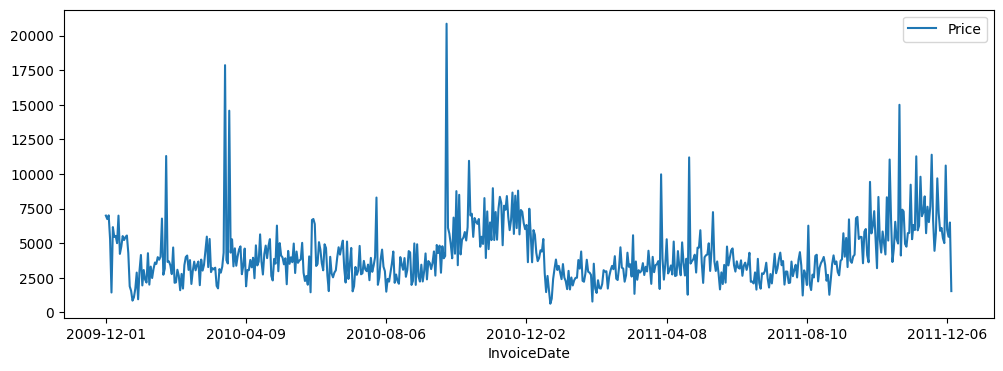

In [356]:
df_grouped = df.groupby('InvoiceDate').agg({'Price': 'sum'})
df_grouped.plot(figsize=(12,4))

plt.show()

## 2.2. Plot Customer's RFM as a Histogram

In [357]:
# set today as one week after the last purchase by the customer

today = pd.to_datetime('2011-12-16')
today

Timestamp('2011-12-16 00:00:00')

In [368]:
df_grouped = df.groupby(['Customer ID']).agg({'Price': 'sum',
                                             'InvoiceDate': 'max',
                                             'Invoice': 'count'})

df_grouped['InvoiceDate'] = pd.to_datetime(df_grouped['InvoiceDate'])
df_grouped['last_purchase'] = (today - df_grouped['InvoiceDate']).dt.days

df_grouped

Price InvoiceDate  Invoice  last_purchase
Customer ID                                             
12346.0       207.40  2011-01-18       34           4818
12347.0       554.57  2011-12-07      222           4495
12348.0       193.10  2011-09-25       51           4568
12349.0      1480.44  2011-11-21      175           4511
12350.0        65.30  2011-02-02       17           4803
...              ...         ...      ...            ...
18283.0      1651.60  2011-12-06      938           4496
18284.0        91.09  2010-10-04       28           4924
18285.0       100.20  2010-02-17       12           5153
18286.0       286.30  2010-08-20       67           4969
18287.0       346.34  2011-10-28      155           4535

[5878 rows x 4 columns]

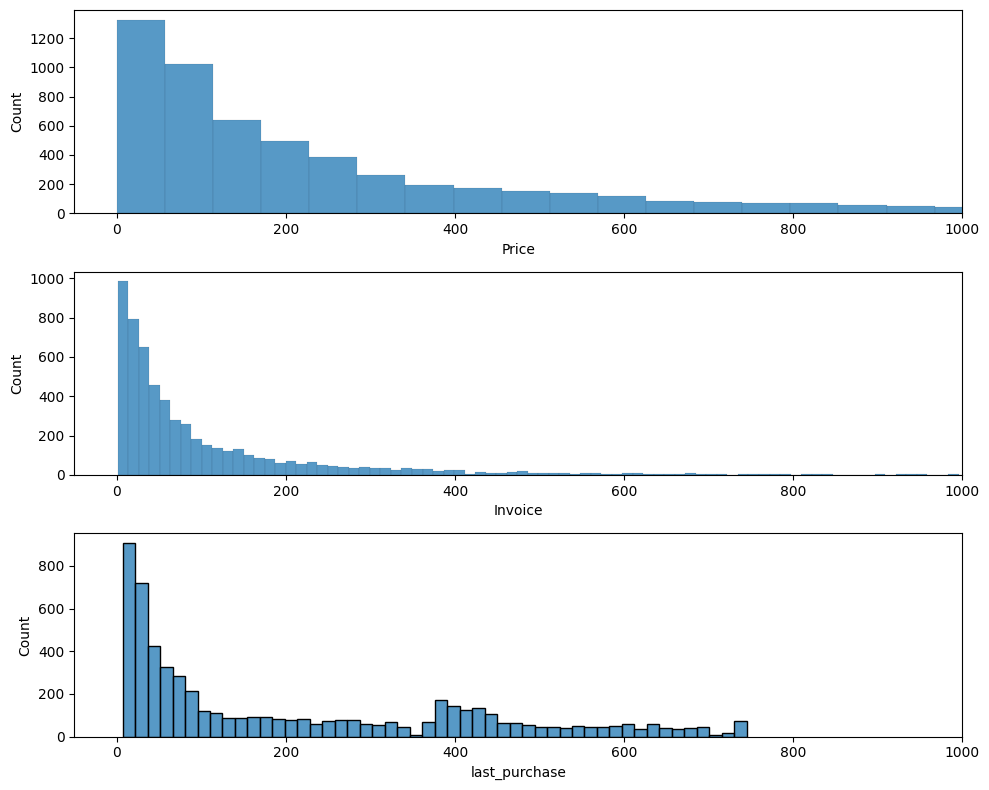

In [73]:
plt.figure(figsize=(10,8))

for i, j in enumerate(['Price', 'Invoice', 'last_purchase']):
    i += 1
    plt.subplot(3, 1, i)
    if j == 'last_purchase':
        bins = 50
    else:
        bins = 1000
    sns.histplot(data=df_grouped, x=df_grouped[j], bins=bins)
    plt.xlim(-50, 1000)

plt.tight_layout()
plt.show()

# 3. RFM Analysis

## 3.1. Simple RFM Analysis

The first simple analysis involves grouping customers by their recency, frequency, and monetary value rankings. We will divide and rank all values into five quintiles. Subsequently, we can categorize them based on any desired names or categories. For example, in this case, we will categorize customers into groups such as 'Hibernating', 'At Risk', "Can't Lose", 'About to Sleep', 'Need Attention', 'Loyal Customers', 'Promising', 'New Customers', 'Potential Loyalists', and 'Champions'. Since this process does not require complex mathematical calculations, you can easily follow the steps outlined below by referring directly to the code.

In [74]:
# make a new dataframe dedicated for rfm

df_rfm = df_grouped.copy(deep=True)
df_rfm = df_rfm[['last_purchase', 'Invoice', 'Price']]
df_rfm = df_rfm.rename(columns={'last_purchase': 'Recency',
                                'Invoice': 'Frequency',
                                'Price': 'Monetary'})
df_rfm.head(5)

Recency  Frequency  Monetary
Customer ID                              
12346.0          332         34    207.40
12347.0            9        222    554.57
12348.0           82         51    193.10
12349.0           25        175   1480.44
12350.0          317         17     65.30

In [75]:
# save the values for every quintile we set
# will be used later if we want to do the rfm segmentation with the same binning again
q_rec = pd.qcut(df_rfm['Recency'], q=5, labels=[5,4,3,2,1], retbins=True)[1]
q_freq = pd.qcut(df_rfm['Frequency'], q=5, labels=[5,4,3,2,1], retbins=True)[1]
q_mon = pd.qcut(df_rfm['Monetary'], q=5, labels=[5,4,3,2,1], retbins=True)[1]

# create rfm score columns
df_rfm['r_score'] = pd.qcut(df_rfm['Recency'], q=5, labels=[5,4,3,2,1])
df_rfm['f_score'] = pd.qcut(df_rfm['Frequency'], q=5, labels=[1,2,3,4,5])
df_rfm['m_score'] = pd.qcut(df_rfm['Monetary'], q=5, labels=[1,2,3,4,5])

# combine all rfm scores
# later on to make the segmentation
df_rfm['rfm_segment'] = df_rfm['r_score'].astype('str') + df_rfm['f_score'].astype('str') + df_rfm['m_score'].astype('str')
df_rfm['rfm_score'] = df_rfm['r_score'].astype('int') + df_rfm['f_score'].astype('int') + df_rfm['m_score'].astype('int')

df_rfm

Recency  Frequency  Monetary r_score f_score m_score rfm_segment  \
Customer ID                                                                     
12346.0          332         34    207.40       2       2       3         223   
12347.0            9        222    554.57       5       5       5         555   
12348.0           82         51    193.10       3       3       3         333   
12349.0           25        175   1480.44       5       5       5         555   
12350.0          317         17     65.30       2       2       2         222   
...              ...        ...       ...     ...     ...     ...         ...   
18283.0           10        938   1651.60       5       5       5         555   
18284.0          438         28     91.09       1       2       2         122   
18285.0          667         12    100.20       1       1       2         112   
18286.0          483         67    286.30       1       3       4         134   
18287.0           49        155    346.34       4       4       4         444   

             rfm_score  
Customer ID             
12346.0              7  
12347.0             15  
12348.0              9  
12349.0             15  
12350.0              6  
...                ...  
18283.0             15  
18284.0              5  
18285.0              4  
18286.0              8  
18287.0             12  

[5878 rows x 8 columns]

### 3.1.1. Segmenting by RFM Segment

In [76]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Loose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

df_rfm['rfm_cat_seg'] = (df_rfm['r_score'].astype('str') + df_rfm['f_score'].astype('str')).replace(seg_map, regex=True)
df_rfm

Recency  Frequency  Monetary r_score f_score m_score rfm_segment  \
Customer ID                                                                     
12346.0          332         34    207.40       2       2       3         223   
12347.0            9        222    554.57       5       5       5         555   
12348.0           82         51    193.10       3       3       3         333   
12349.0           25        175   1480.44       5       5       5         555   
12350.0          317         17     65.30       2       2       2         222   
...              ...        ...       ...     ...     ...     ...         ...   
18283.0           10        938   1651.60       5       5       5         555   
18284.0          438         28     91.09       1       2       2         122   
18285.0          667         12    100.20       1       1       2         112   
18286.0          483         67    286.30       1       3       4         134   
18287.0           49        155    346.34       4       4       4         444   

             rfm_score      rfm_cat_seg  
Customer ID                              
12346.0              7      Hibernating  
12347.0             15        Champions  
12348.0              9   Need Attention  
12349.0             15        Champions  
12350.0              6      Hibernating  
...                ...              ...  
18283.0             15        Champions  
18284.0              5      Hibernating  
18285.0              4      Hibernating  
18286.0              8          At Risk  
18287.0             12  Loyal Customers  

[5878 rows x 9 columns]

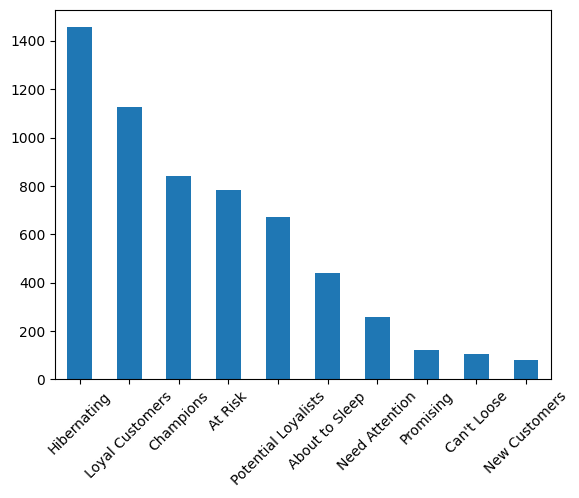

In [77]:
# plot on the size of each segment

df_rfm['rfm_cat_seg'].value_counts().plot(kind='bar')

plt.xticks(rotation=45)
plt.show()

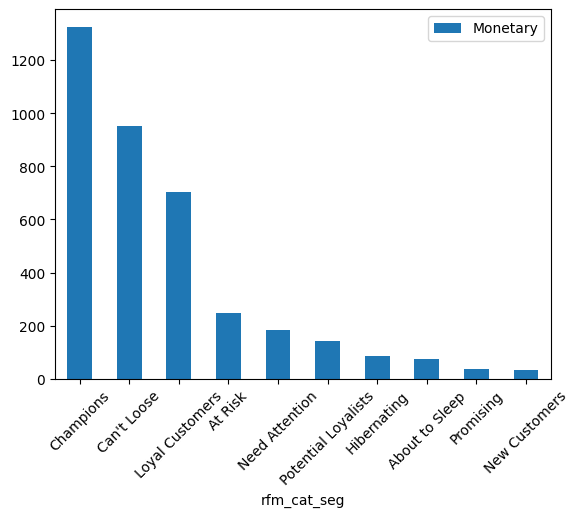

In [78]:
# plot based on monetary value of each group

df_rfm.groupby('rfm_cat_seg').agg({'Monetary': 'mean'}).sort_values('Monetary', ascending=False).plot(kind='bar')

plt.xticks(rotation=45)
plt.show()

### 3.1.2. Segmenting by RFM Score

In [79]:
def categorize_rfm(score):
    if score == 15:
        return 'Best Customers'
    elif score in (14, 13):
        return 'Loyal Customers'
    elif score in (12, 11):
        return 'Potential Loyalists'
    elif score in (10, 9):
        return 'Promising Customers'
    elif score in (8, 7):
        return 'Needing Attention'
    elif score in (6, 5):
        return 'About to Sleep'
    elif score in (4, 3):
        return 'At Risk'
    else:
        return 'Other'
    
df_rfm['rfm_cat_score'] = df_rfm['rfm_score'].apply(categorize_rfm)
df_rfm

Recency  Frequency  Monetary r_score f_score m_score rfm_segment  \
Customer ID                                                                     
12346.0          332         34    207.40       2       2       3         223   
12347.0            9        222    554.57       5       5       5         555   
12348.0           82         51    193.10       3       3       3         333   
12349.0           25        175   1480.44       5       5       5         555   
12350.0          317         17     65.30       2       2       2         222   
...              ...        ...       ...     ...     ...     ...         ...   
18283.0           10        938   1651.60       5       5       5         555   
18284.0          438         28     91.09       1       2       2         122   
18285.0          667         12    100.20       1       1       2         112   
18286.0          483         67    286.30       1       3       4         134   
18287.0           49        155    346.34       4       4       4         444   

             rfm_score      rfm_cat_seg        rfm_cat_score  
Customer ID                                                   
12346.0              7      Hibernating    Needing Attention  
12347.0             15        Champions       Best Customers  
12348.0              9   Need Attention  Promising Customers  
12349.0             15        Champions       Best Customers  
12350.0              6      Hibernating       About to Sleep  
...                ...              ...                  ...  
18283.0             15        Champions       Best Customers  
18284.0              5      Hibernating       About to Sleep  
18285.0              4      Hibernating              At Risk  
18286.0              8          At Risk    Needing Attention  
18287.0             12  Loyal Customers  Potential Loyalists  

[5878 rows x 10 columns]

## 3.2. Sophisticated RFM Analysis Using K-Means

Next, we will use K-Means. KMeans is a popular clustering algorithm used in machine learning for partitioning a dataset into K distinct, non-overlapping clusters. The goal of KMeans is to group similar data points together and discover underlying patterns in the data. It works by iteratively assigning each data point to the nearest cluster centroid and then recalculating the centroids based on the mean of the points in each cluster. This process is repeated until the centroids no longer change significantly or a specified number of iterations is reached.

One of the key advantages of KMeans is its simplicity and efficiency, making it suitable for clustering large datasets. However, it has some limitations, such as the need to specify the number of clusters (K) in advance, sensitivity to initial centroid selection, and its tendency to produce spherical clusters.

Let's follow the steps below!

### 3.2.1. Data Preprocessing

K-Means would perform the best under two conditions:

1. Data distribution is not skewed
2. Data is standardized ($\mu=0, \sigma=1$)

Thus, we will preprocess the data first to make the data distributed normally.

#### 3.2.1.1. Check Skewness of the Data

In [80]:
from scipy import stats

def check_skew(df, col):
    skew_val = stats.skew(df[col])
    skew_test = stats.skewtest(df[col])
    
    sns.displot(df[col], kde=True, height=4, aspect=1.5)
    plt.title('Distribution of ' + col)

    print("{}'s: Skew: {}, : {}".format(col, skew_val, skew_test))

    return plt.show()

Recency's: Skew: 0.8869672343626458, : SkewtestResult(statistic=24.091560514508277, pvalue=3.0644844953748973e-128)


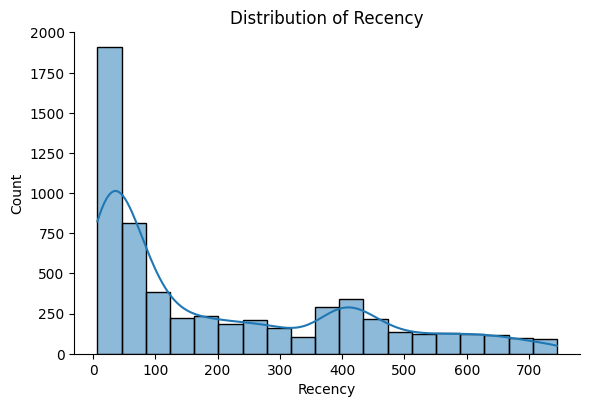

Frequency's: Skew: 18.158094374932563, : SkewtestResult(statistic=97.25821501648038, pvalue=0.0)


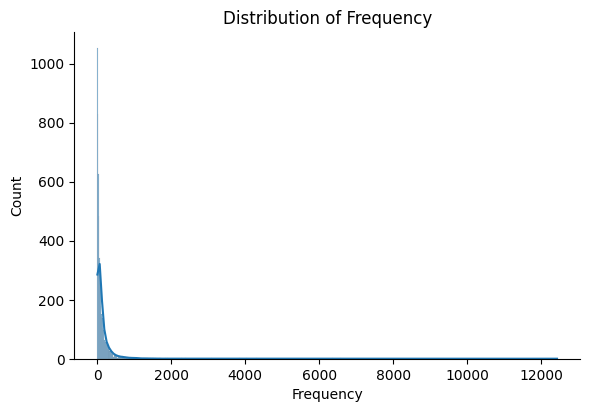

Monetary's: Skew: 22.468475665166473, : SkewtestResult(statistic=102.71441402679707, pvalue=0.0)


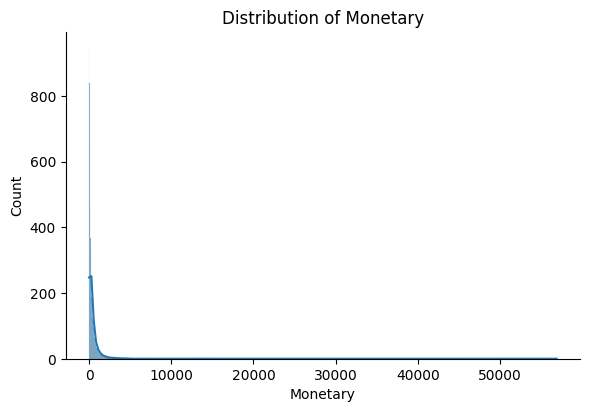

In [81]:
for col in ['Recency', 'Frequency', 'Monetary']:
    check_skew(df_rfm, col)

In [82]:
df_rfm.head()

Recency  Frequency  Monetary r_score f_score m_score rfm_segment  \
Customer ID                                                                     
12346.0          332         34    207.40       2       2       3         223   
12347.0            9        222    554.57       5       5       5         555   
12348.0           82         51    193.10       3       3       3         333   
12349.0           25        175   1480.44       5       5       5         555   
12350.0          317         17     65.30       2       2       2         222   

             rfm_score     rfm_cat_seg        rfm_cat_score  
Customer ID                                                  
12346.0              7     Hibernating    Needing Attention  
12347.0             15       Champions       Best Customers  
12348.0              9  Need Attention  Promising Customers  
12349.0             15       Champions       Best Customers  
12350.0              6     Hibernating       About to Sleep

#### 3.2.1.2. Remove Skewness of the Data

There are two ways to remove the skewness of the data. One of the most popular methods is by taking logarithmic value of it, and the second one is to use the Box-Cox algorithm. The formulas are as follow:

- $\text{Logarithmic: } X(log) = log(X)$
- $\text{Box-Cox: } X^{(\lambda)} = \frac{X^{\lambda} - 1}{\lambda}$

What are the differences between two of them?

- **Logarithmic:**
    - Simpler: It's a single operation (logarithm) applied to the data.
    - Limited for zeros: Logarithm is undefined for zero values, so the data needs to be positive or transformed to avoid zeros.
    - Less flexible: The logarithmic transformation might not be as effective for all types of skewness compared to Box-Cox.
- **Box-cox:**
    - More flexible: It uses a lambda (λ) parameter that can take on different values, allowing for a wider range of transformations depending on the data's skewness (positive or negative)
    - Handles zero values: It can be applied to data containing zeros by adding a small constant before the transformation.
    - More complex to implement: Finding the optimal lambda value involves statistical tests or optimization algorithms.

Let's try to use both of them and see which one works for our data to make it normal.

In [83]:
df_rfm_log = df_rfm[['Recency', 'Frequency', 'Monetary']].copy(deep=True)


Recency's: Skew: -0.19878326748238745, : SkewtestResult(statistic=-6.170023484967673, pvalue=6.827985036227071e-10)


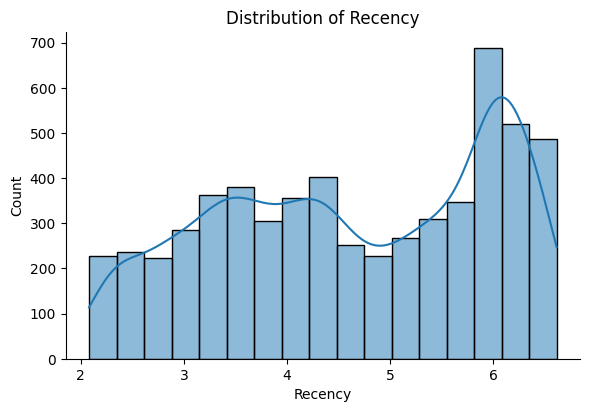

Frequency's: Skew: -0.027663328004561484, : SkewtestResult(statistic=-0.8667881142672751, pvalue=0.38605811564395087)


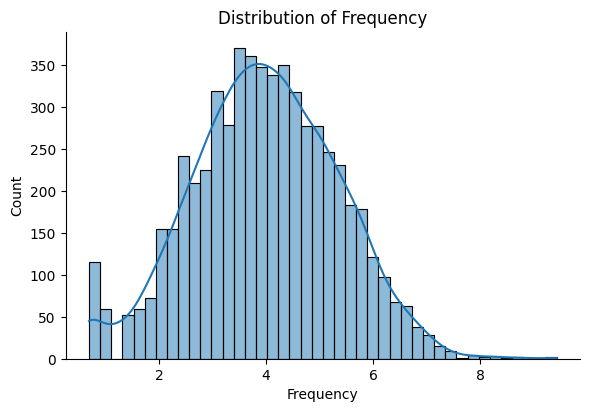

Monetary's: Skew: -0.2520050881342928, : SkewtestResult(statistic=-7.777839242525258, pvalue=7.377373208373882e-15)


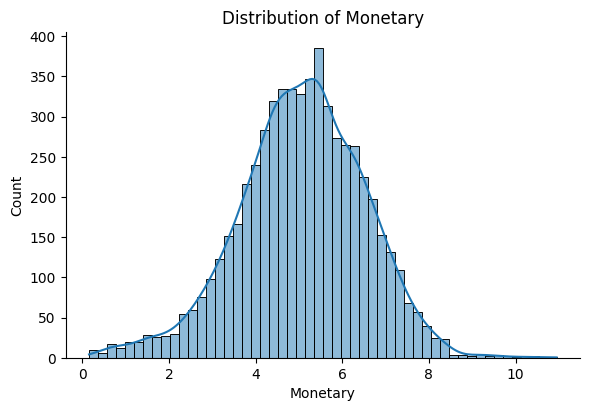

In [84]:
# removing skewness of the data by taking logarithmic value
# still have skewness on recency and monetary

df_rfm_log = df_rfm[['Recency', 'Frequency', 'Monetary']].copy(deep=True)

# log + 1 (small constant) to avoid negative values
# log transformation demands all the values to be positive

df_rfm_log = np.log(df_rfm_log + 1)

check_skew(df_rfm_log,'Recency')
check_skew(df_rfm_log,'Frequency')
check_skew(df_rfm_log,'Monetary')

Recency's: Skew: -0.06635010627493683, : SkewtestResult(statistic=-2.0771022193309987, pvalue=0.03779212579974806)


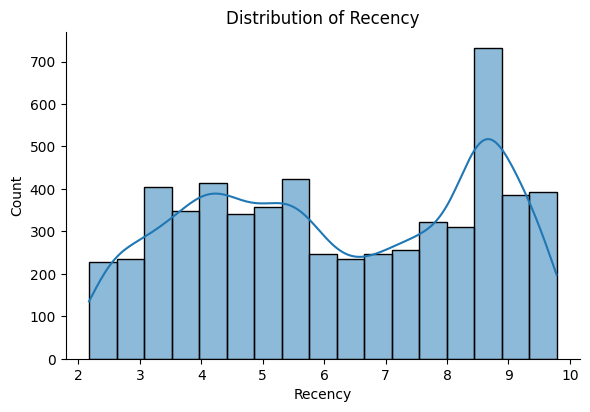

Frequency's: Skew: 0.0032395578360877864, : SkewtestResult(statistic=0.10152566886218183, pvalue=0.9191331820254567)


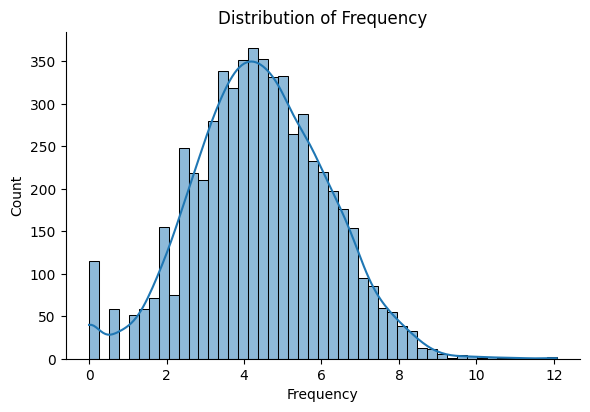

Monetary's: Skew: 0.020819893814243515, : SkewtestResult(statistic=0.6524134327556047, pvalue=0.5141345011224547)


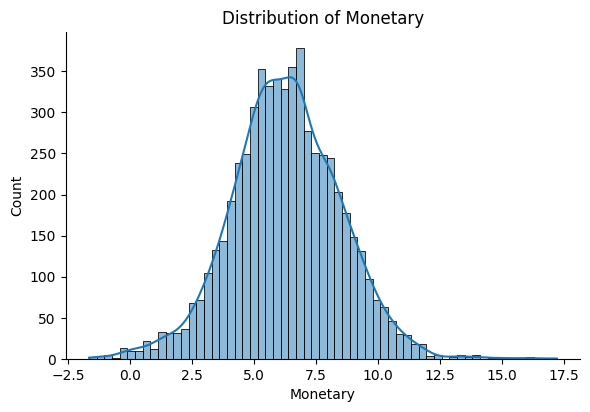

In [85]:
# removing skewness of the data by transforming data using BoxCox
# only skewness found in recency

from scipy.stats import boxcox

df_rfm_log = df_rfm[['Recency', 'Frequency', 'Monetary']].copy(deep=True)

for col in df_rfm_log.columns:
    transformed_data, _ = boxcox(df_rfm_log[col])
    df_rfm_log[col] = transformed_data

check_skew(df_rfm_log,'Recency')
check_skew(df_rfm_log,'Frequency')
check_skew(df_rfm_log,'Monetary')

### 3.2.1.3. Standardizing the Data (Mean of 0 and Standard Deviation of 1)

In [87]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_rfm_log)

df_rfm_scaled = scaler.transform(df_rfm_log)
df_rfm_scaled = pd.DataFrame(df_rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
df_rfm_scaled.head()

Recency  Frequency  Monetary
0  0.874071  -0.312931  0.144034
1 -1.659983   1.036884  0.853789
2 -0.230645  -0.031955  0.094551
3 -1.042685   0.858597  1.618249
4  0.834725  -0.780162 -0.623850

### 3.2.2. Calculation

#### 3.2.2.1. Finding Optimal Number of Clusters

Number of clusters really depend on the business needs. The more clusters we have, the more difficult it is to take an action based on that. But, if we want to use the mathematical way, then we can use the **elbow method** to determine the best number for the clusters (k). It involves plotting the within-cluster sum of squares (inertia) as a function of the number of clusters and looking for the "elbow" point, where the rate of decrease in inertia sharply changes. To determine that, we have to calculate the distortion and inertia metrics for evaluating the quality of the clustering. What are those?

##### **Distortion:** The distortion is the average of the squared distances between each data point and its closest cluster center. 

It is calculated as:

$\text{Distortion} = \frac{1}{n} \sum_{i=1}^{n} \left( \text{min}_{j=1}^{k} ||\text{data point } i - \text{cluster center } j||^2 \right)$

Where:
1. $n$ is the total number of data points.
2. $k$ is the total number of clusters.
3. $\text{min}_{j=1}^{k} ||\text{data point } i - \text{cluster center } j||$ is the minimum Euclidean distance between data point \( i \) and any of the cluster centers.

##### **Inertia:** Also known as within-cluster sum of squares, is the sum of squared distances of samples to their closest cluster center. 

The formula is as follow:

$\text{Inertia} = \sum_{i=1}^{n} \left( \text{min}_{j=1}^{k} ||\text{data point } i - \text{cluster center } j||^2 \right)$

Where the terms are the same as in the distortion formula. In the context of the code snippet, `model.inertia_` provides the inertia of the K-means model directly. This metric is used to evaluate the spread of clusters; lower inertia values indicate more compact clusters.

In [106]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

distortions = []
inertias = []

# mapping 1 stores the sum of minimum distances from each sample to the cluster center for each value of k. 
# the key is the value of k, and the value is the corresponding sum of minimum distances.
mapping1 = {}

# mapping 2 stores the inertia of the KMeans model for each value of k. 
# the key is the value of k, and the value is the corresponding inertia.
mapping2 = {}

# range of K we want to test using elbow method
K = range(1,10)

for k in K:
    model = KMeans(n_clusters=k).fit(df_rfm_scaled)

    distortions.append(sum(np.min(cdist(df_rfm_scaled, model.cluster_centers_, 'euclidean'),axis=1)) / df_rfm_scaled.shape[0]) 
    inertias.append(model.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(df_rfm_scaled, model.cluster_centers_, 'euclidean'),axis=1)) / df_rfm_scaled.shape[0] 
    mapping2[k] = model.inertia_

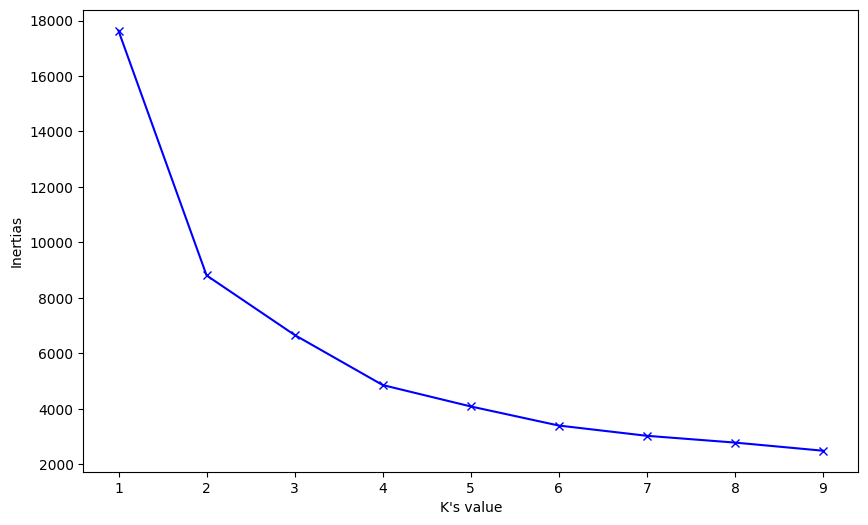

In [107]:
plt.figure(figsize=(10,6))

plt.plot(K, inertias, '-bx')
plt.xlabel("K's value")
plt.ylabel("Inertias")

plt.show()

There's one biggest drawback using the Elbow Method: In the majority of the real-world data sets, there’s not a clear elbow inflection point to identify the right ‘K’ using the elbow method. This makes it easier to find the wrong K. In this case, we can turn to **Silhouette Score**. The Silhouette score is a very useful method to find the number of K when the elbow method doesn’t show the elbow point. It measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation).

The formula for the silhouette score of a single data point is:

$S = \frac{b-a}{max(a,b)}$

where...

- $s$ is the silhouette score of the data point.
- $a$ is the mean distance between a data point and all other points in the same cluster.
- $b$ is the mean distance between a data point and all points in the nearest cluster that the data point is not part of.

The silhouette score ranges from -1 to 1. A score closer to 1 indicates that the data point is well matched to its own cluster and poorly matched to neighboring clusters. A score near 0 indicates that the data point is on or very close to the decision boundary between two neighboring clusters. A score less than 0 indicates that the data point may have been assigned to the wrong cluster.

**How to Use the Silhouette Method in Python?**

We can create a silhouette plot, like following. After that, determine the best K based on:

1. The highest silhouette score. But, that’s not sufficient to select the optimal K.
2. For a particular K, all the clusters should have a Silhouette score greater than the average score of the data set represented by the red-dotted line. The x-axis represents the Silhouette score. 
3. There shouldn’t be wide fluctuations in the size of the clusters. The width of the clusters represents the number of data points. 

For more about silhouette score and plot, you can check on the documentation from scikit-learn <a href='https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html'>here</a>.

For n_clusters = 2 The average silhouette_score is : 0.4327153112160817
For n_clusters = 3 The average silhouette_score is : 0.34083439520518544
For n_clusters = 4 The average silhouette_score is : 0.3834028407842925
For n_clusters = 5 The average silhouette_score is : 0.3645486053948911


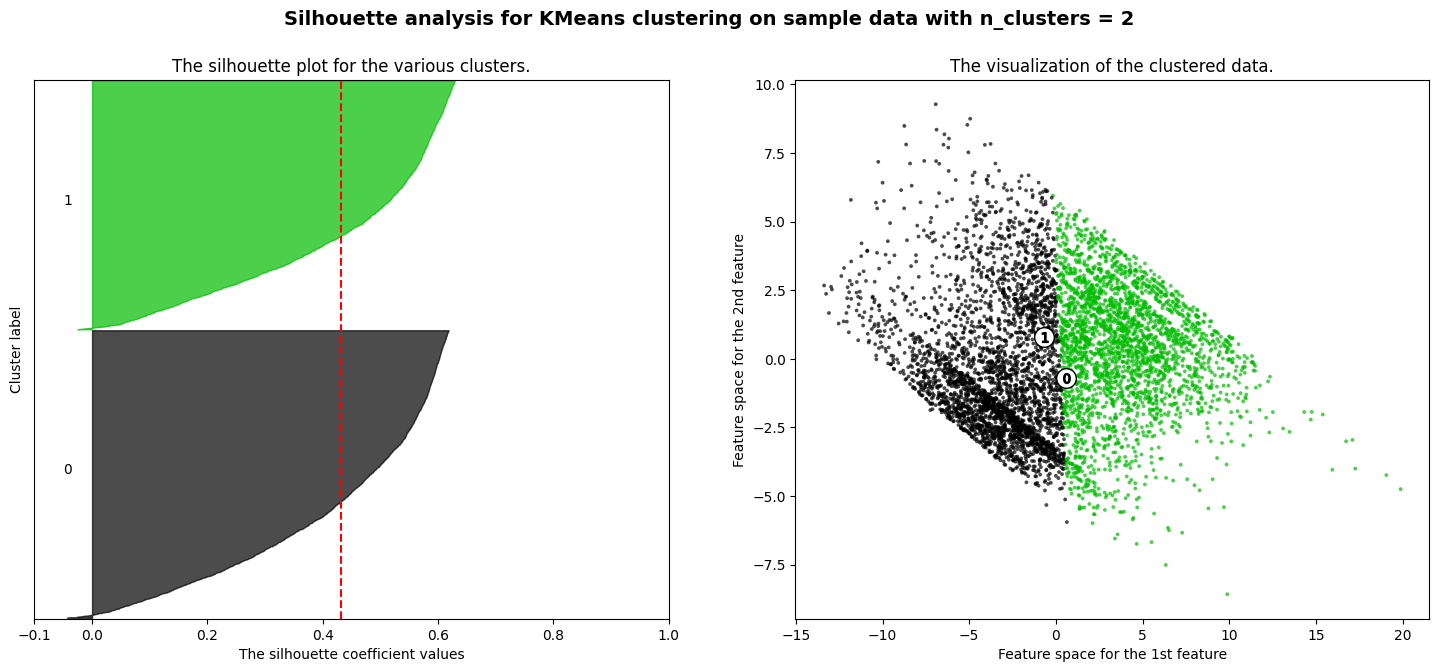

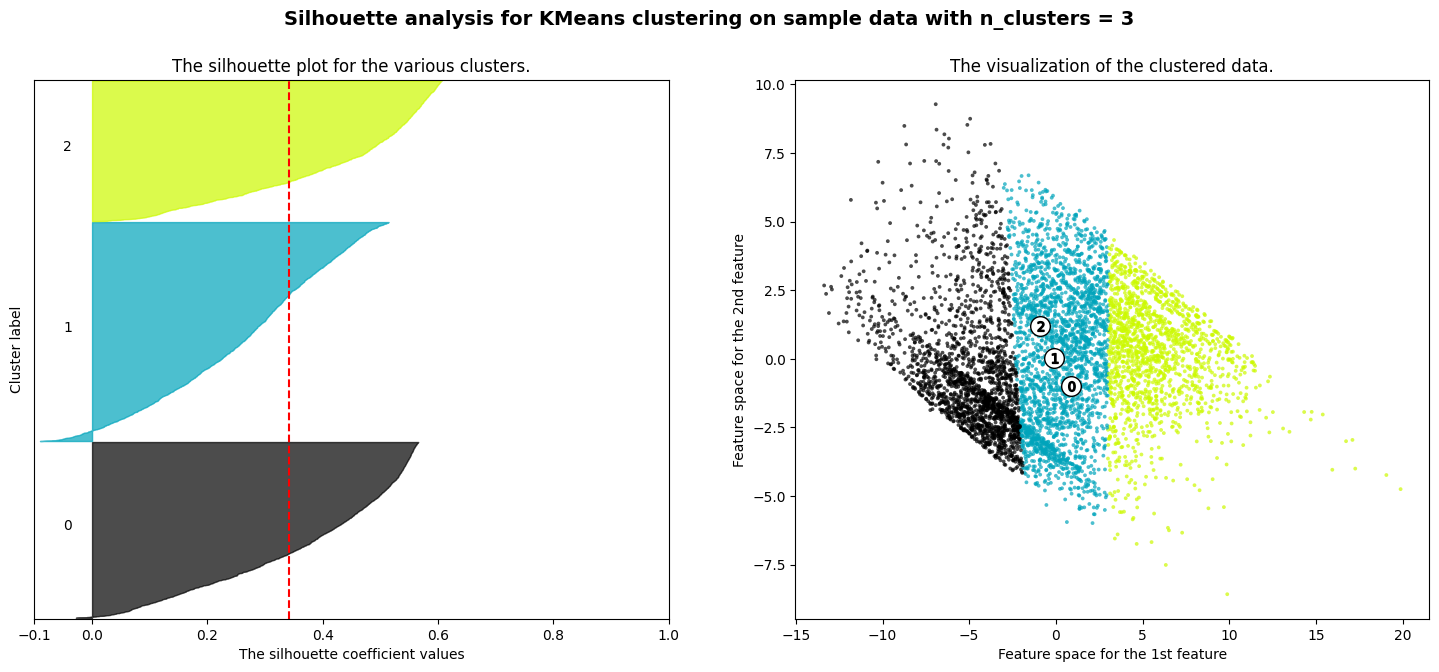

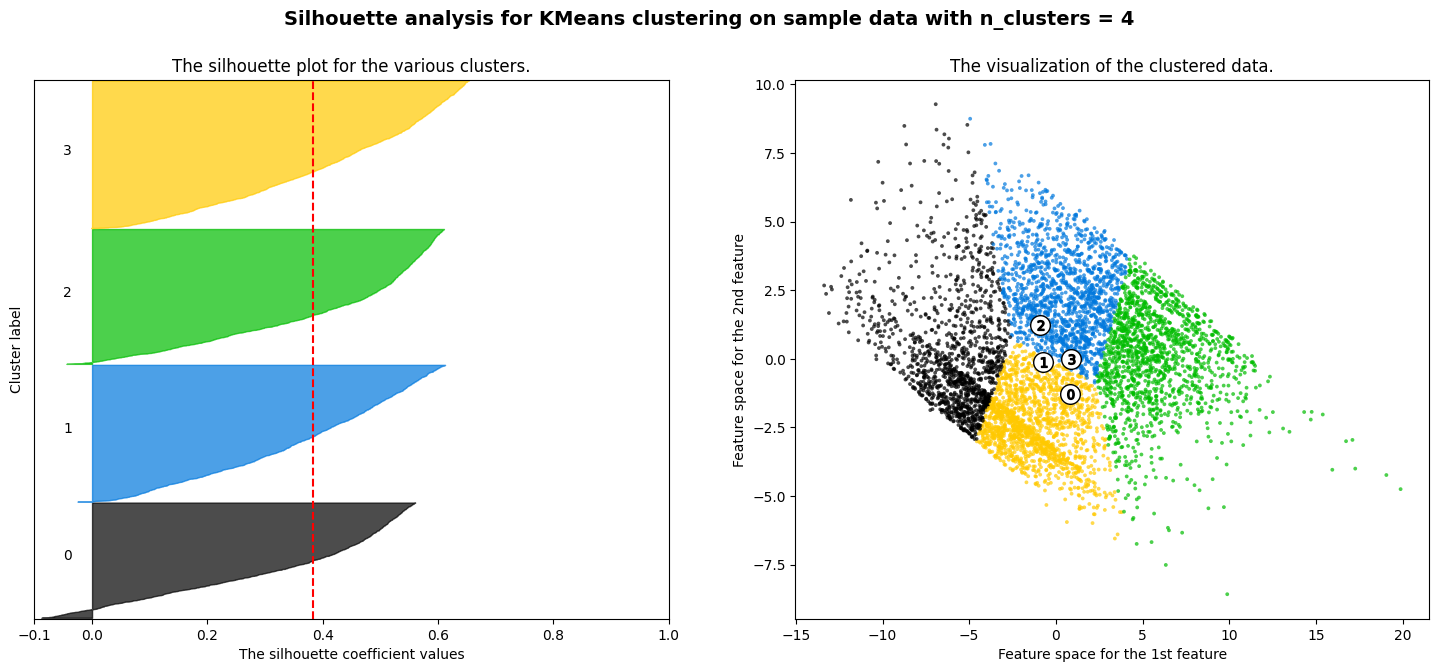

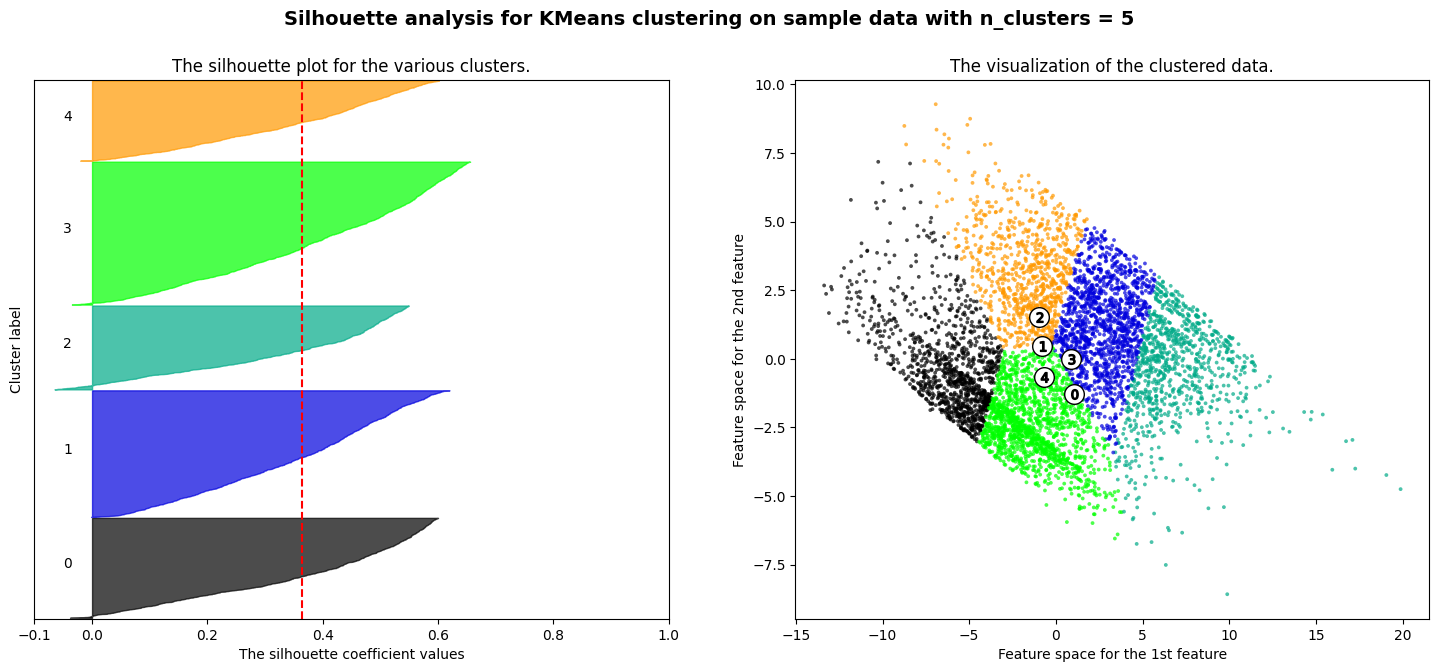

In [137]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import decomposition

K = range(2, 6)

for n_clusters in K:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_rfm_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_rfm_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_rfm_scaled, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_rfm_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

    n = 2
    pca = decomposition.PCA(n_components=n)
    pca_res = pca.fit_transform(df_rfm_scaled)

    ax2.scatter(
        pca_res[:, 0], pca_res[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

### 3.2.3. Fitting and Recommendation

Now, let's fit, train, and plot our data. As we have 3 variables (Recency, Frequency, Monetary), it would be difficult to plot it in a 2D plot. So, how can we do that? We can use the t-SNE (t-distributed Stochastic Neighbor Embedding) algorithm aims to reduce the dimensionality of a dataset while preserving the pairwise similarities between data points. It is particularly useful for visualizing high-dimensional data in low-dimensional space, often for clustering or visualization purposes.

The formula for t-SNE can be broken down into two main components: the similarity between data points in the high-dimensional space and the similarity between the corresponding points in the low-dimensional space.

The t-SNE (t-distributed Stochastic Neighbor Embedding) algorithm aims to reduce the dimensionality of a dataset while preserving the pairwise similarities between data points. It is particularly useful for visualizing high-dimensional data in low-dimensional space, often for clustering or visualization purposes.

The formula for t-SNE can be broken down into two main components: the similarity between data points in the high-dimensional space and the similarity between the corresponding points in the low-dimensional space.

1. **High-Dimensional Similarities (Pij)**:
   - For each pair of data points i and j, the high-dimensional similarity is calculated as a conditional probability that represents the likelihood of choosing j as a neighbor of i, given the similarity of all other points to i. This is defined as:
   
     $p_{j|i} = \frac{\exp(-||x_i - x_j||^2 / 2\sigma_i^2)}{\sum_{k \neq i} \exp(-||x_i - x_k||^2 / 2\sigma_i^2)}$

     Where:
     - $x_i$ and $x_j$ are the high-dimensional representations of data points i and j.
     - $\sigma_i$ is the variance of the Gaussian distribution around data point i.

2. **Low-Dimensional Similarities (Qij)**:
   - Similarly, for the low-dimensional space, the similarity between data points i and j is calculated as a conditional probability based on the Euclidean distances in the low-dimensional space, normalized by a factor:
   
     $q_{j|i} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum_{k \neq i} (1 + ||y_i - y_k||^2)^{-1}}$

     Where: $y_i$ and $y_j$ are the low-dimensional representations of data points i and j.

3. **Objective Function**:
   - t-SNE minimizes the Kullback-Leibler divergence between the high-dimensional similarities (Pij) and the low-dimensional similarities (Qij) using gradient descent. The objective function is defined as:

     $C = \sum_i KL(P_i || Q_i) = \sum_i \sum_j p_{j|i} \log \frac{p_{j|i}}{q_{j|i}}$

     Where: $( KL(P_i || Q_i)$ is the Kullback-Leibler divergence between the distributions $P_i$ and $Q_i$ for data point i.

The t-SNE algorithm iteratively adjusts the low-dimensional representations $y_i$ to minimize the objective function C, effectively reducing the dimensionality of the data while preserving the local and global structure as much as possible. For more information about the algorithm, you can check the documentation from scikit-learn from <a href='https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html'>here.</a>

In [302]:
df_rfm_ori = df_rfm[['Recency', 'Frequency', 'Monetary']].reset_index(drop=True)
df_rfm_ori.head()

Recency  Frequency  Monetary
0      332         34    207.40
1        9        222    554.57
2       82         51    193.10
3       25        175   1480.44
4      317         17     65.30

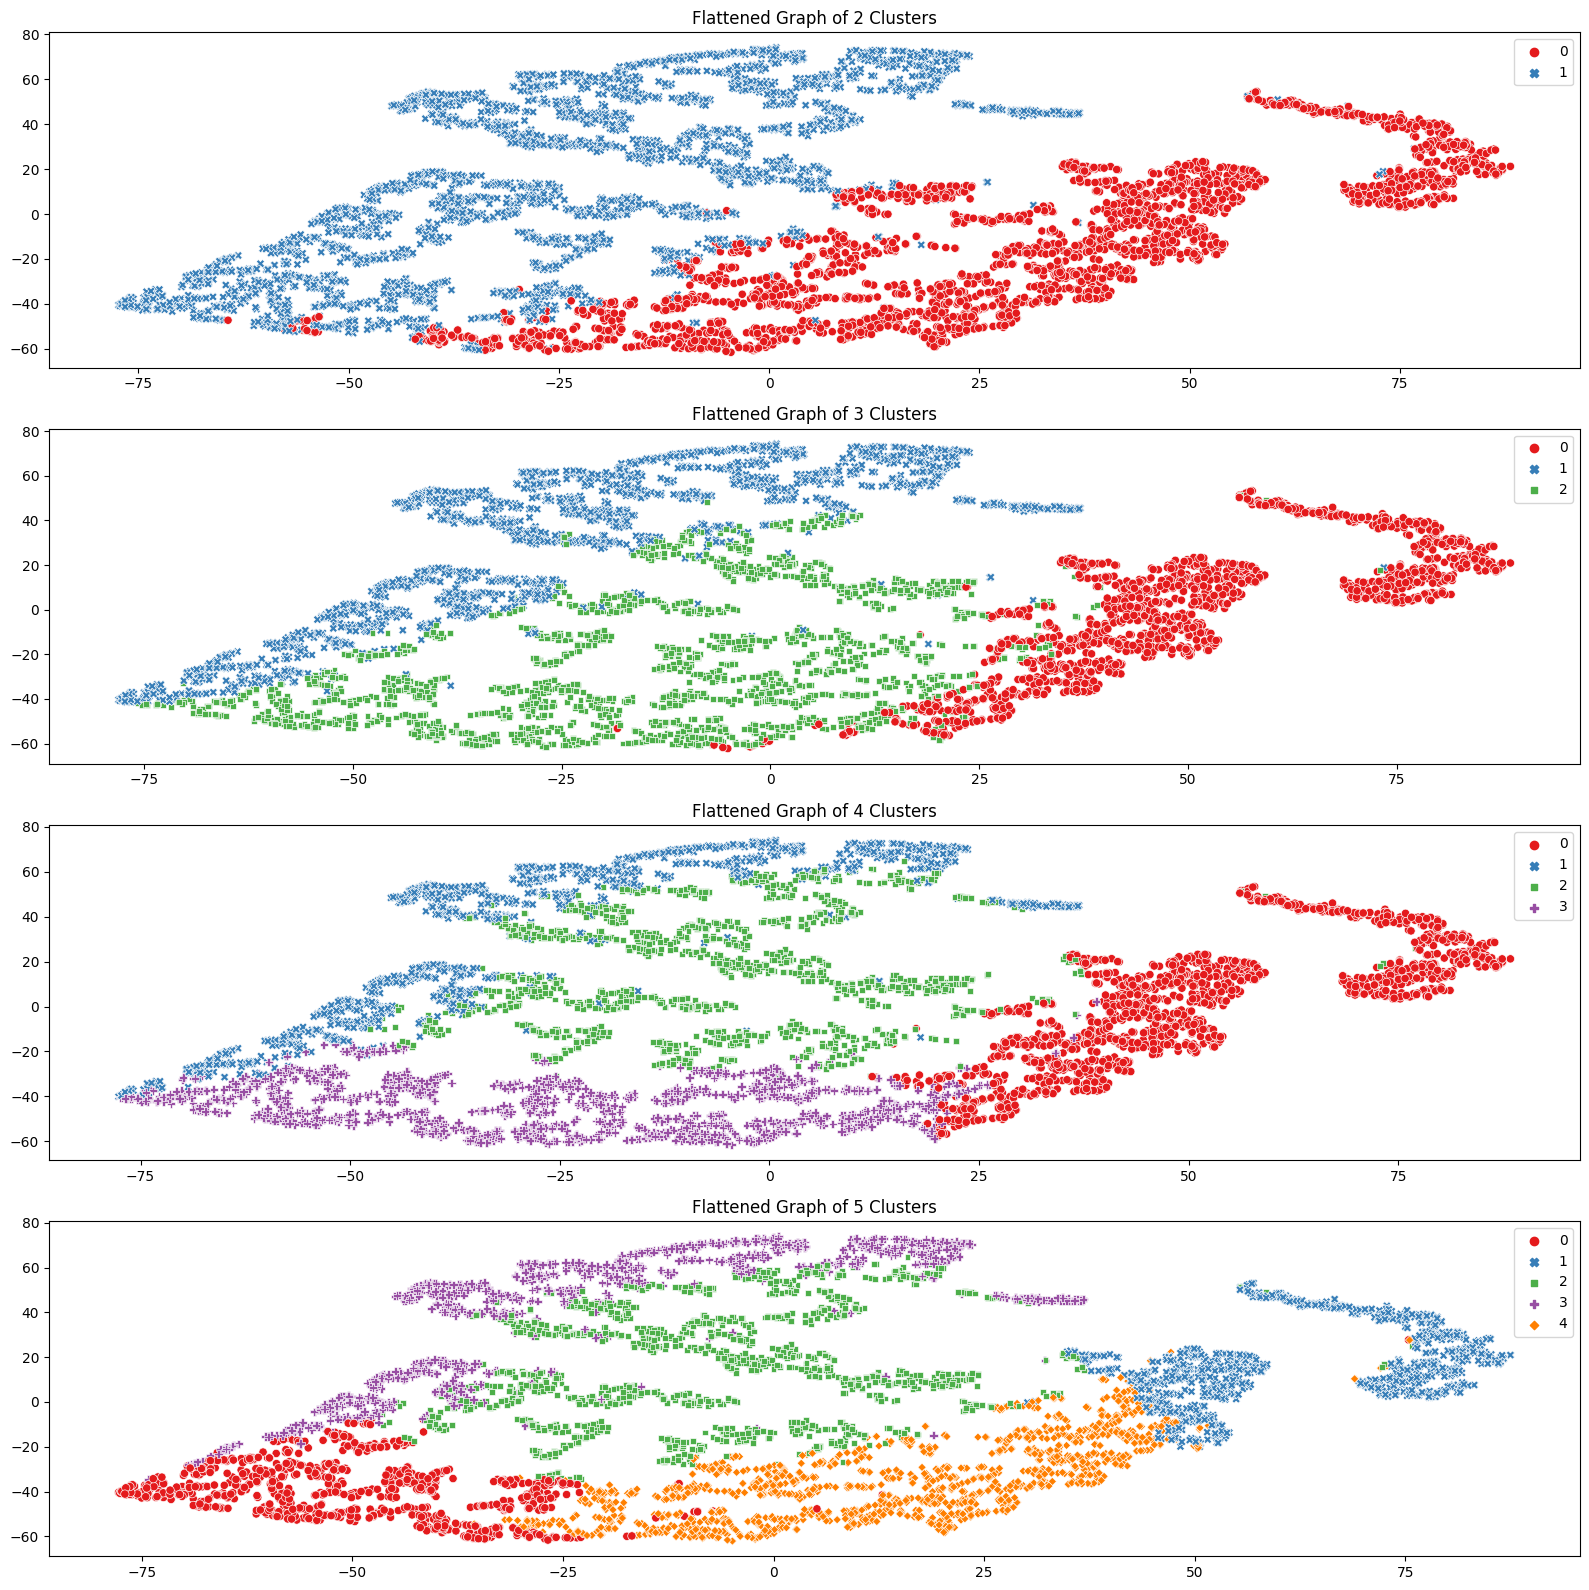

In [303]:
from sklearn.manifold import TSNE

def kmeans_plot(df_rfm_scaled, df_rfm_ori, n_clusters, return_df=False):
    # fit the kmeans model
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(df_rfm_scaled)

    cluster_labels = kmeans.labels_

    # asssing cluster label
    # and calculate the tsne based on this df
    df_new = df_rfm_ori.assign(Cluster=cluster_labels)
    tsne = TSNE()
    transformed = tsne.fit_transform(df_new)

    # create t-sne plot
    plt.title('Flattened Graph of {} Clusters'.format(n_clusters))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")

    if return_df:
        return df_new
    else:
        return 

# create the graph for this and the dataframe for it as well
# make a subplot out of them
    
plt.figure(figsize=(16,16))

plt.subplot(4, 1, 1)
df_rfm_k2 = kmeans_plot(df_rfm_scaled, df_rfm_ori, 2, return_df=True)

plt.subplot(4, 1, 2)
df_rfm_k3 = kmeans_plot(df_rfm_scaled, df_rfm_ori, 3, return_df=True)

plt.subplot(4, 1, 3)
df_rfm_k4 = kmeans_plot(df_rfm_scaled, df_rfm_ori, 4, return_df=True)

plt.subplot(4, 1, 4)
df_rfm_k5 = kmeans_plot(df_rfm_scaled, df_rfm_ori, 5, return_df=True)

plt.tight_layout()
plt.show()

In [241]:
# take the df_ori with the customer_id
# we need this now later to melt the data into long format

df_rfm_ori = df_rfm.reset_index()[['Customer ID', 'Recency', 'Frequency', 'Monetary']]
df_rfm_ori.head()

Customer ID  Recency  Frequency  Monetary
0      12346.0      332         34    207.40
1      12347.0        9        222    554.57
2      12348.0       82         51    193.10
3      12349.0       25        175   1480.44
4      12350.0      317         17     65.30

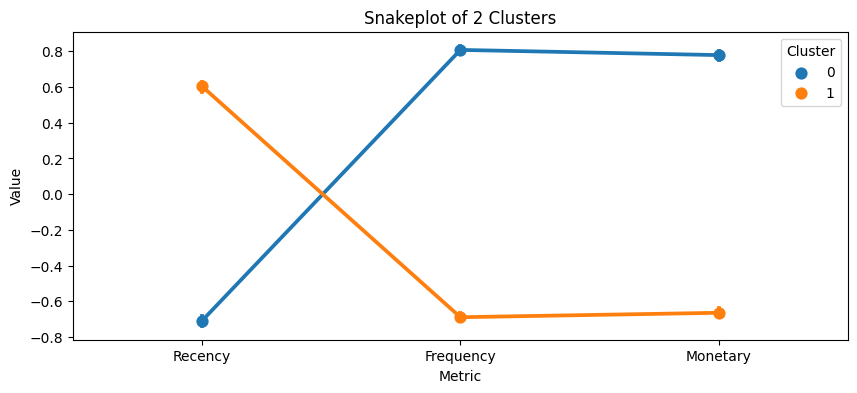

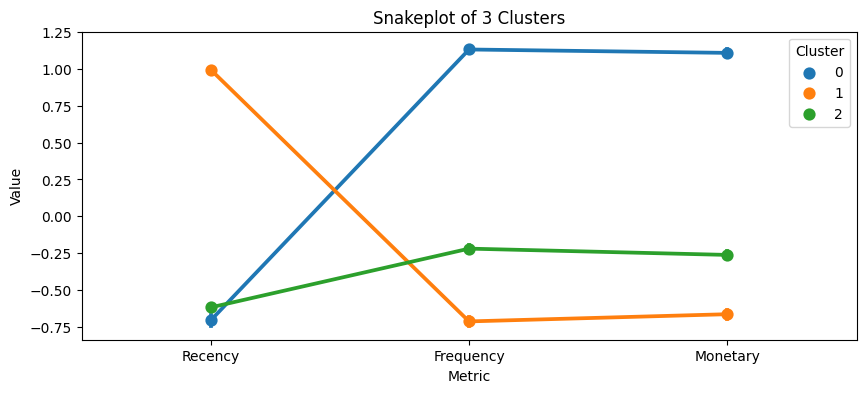

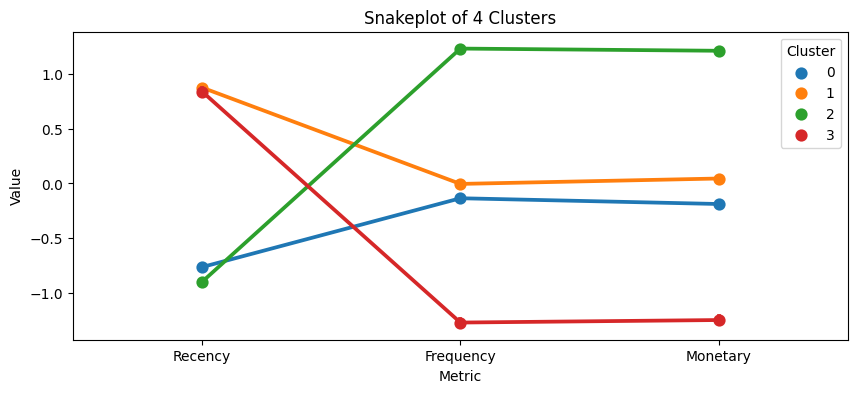

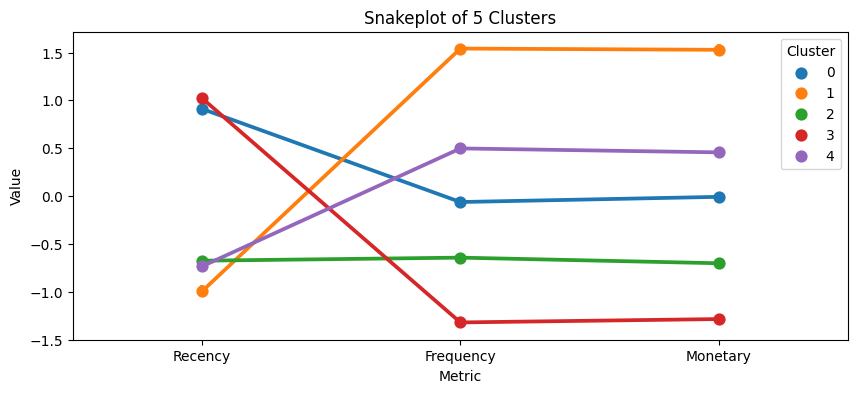

In [262]:
# plotting using snake plot to see the real meaning of every segmentation, so we can give name for every segment

def snake_plot(df_rfm_scaled, df_rfm_kmeans, df_rfm_ori):    
    df_rfm_scaled['Customer ID'] = df_rfm_ori['Customer ID']
    df_rfm_scaled['Cluster'] = df_rfm_kmeans['Cluster']
    
    # melt data into long format
    df_melt = pd.melt(df_rfm_scaled.reset_index(), 
                      id_vars=['Customer ID', 'Cluster'],
                      value_vars=['Recency', 'Frequency', 'Monetary'], 
                      var_name='Metric', 
                      value_name='Value')
    
    n_clusters = df_rfm_scaled['Cluster'].max() + 1
    
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.title('Snakeplot of {} Clusters'.format(n_clusters))

    return sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')

# now we can plot to see and naming of every segment

plt.figure(figsize=(10,4))
snake_plot(df_rfm_scaled, df_rfm_k2, df_rfm_ori)

plt.figure(figsize=(10,4))
snake_plot(df_rfm_scaled, df_rfm_k3, df_rfm_ori)

plt.figure(figsize=(10,4))
snake_plot(df_rfm_scaled, df_rfm_k4, df_rfm_ori)

plt.figure(figsize=(10,4))
snake_plot(df_rfm_scaled, df_rfm_k5, df_rfm_ori)

plt.show()

# 4. RFM Analysis Using a Custom-made Library

## 4.1. Simple RFM

In [422]:
# check our original data again
df.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

  InvoiceDate  Price  Customer ID         Country  
0  2009-12-01   6.95      13085.0  United Kingdom  
1  2009-12-01   6.75      13085.0  United Kingdom  
2  2009-12-01   6.75      13085.0  United Kingdom  
3  2009-12-01   2.10      13085.0  United Kingdom  
4  2009-12-01   1.25      13085.0  United Kingdom

In [428]:
from rfm_segment import preprocess

# make an instance to process the dataframe
df_preprocessed = preprocess.PreprocessTransaction(df, 
                                                   id_col= 'Customer ID',
                                                   rfm_cols=['InvoiceDate', 'Quantity', 'Price'])

# call pivot_transaction to group customer based on their recency, frequency, and monetary
df_preprocessed = df_preprocessed.pivot_transacions()
df_preprocessed

Recency  Frequency  Monetary
Customer ID                              
12346.0         4818         34    207.40
12347.0         4495        222    554.57
12348.0         4568         51    193.10
12349.0         4511        175   1480.44
12350.0         4803         17     65.30
...              ...        ...       ...
18283.0         4496        938   1651.60
18284.0         4924         28     91.09
18285.0         5153         12    100.20
18286.0         4969         67    286.30
18287.0         4535        155    346.34

[5878 rows x 3 columns]

In [457]:
import rfm_segment
from rfm_segment import simplerfm

# make data tables for kmeans
df_rfm_new = simplerfm.RFMTable(df_preprocessed)
df_rfm_new = df_rfm_new.rfm_table()

df_rfm_new.head()

Recency  Frequency  Monetary r_score f_score m_score rfm_segment  \
Customer ID                                                                     
12346.0         4818         34    207.40       2       2       3         223   
12347.0         4495        222    554.57       5       5       5         555   
12348.0         4568         51    193.10       3       3       3         333   
12349.0         4511        175   1480.44       5       5       5         555   
12350.0         4803         17     65.30       2       2       2         222   

             rfm_score     rfm_cat_seg  
Customer ID                             
12346.0              7     Hibernating  
12347.0             15       Champions  
12348.0              9  Need Attention  
12349.0             15       Champions  
12350.0              6     Hibernating

## 4.2. RFM Using KMeans

Recency's: Skew: -0.06635010627493683, : SkewtestResult(statistic=-2.0771022193309987, pvalue=0.03779212579974806)


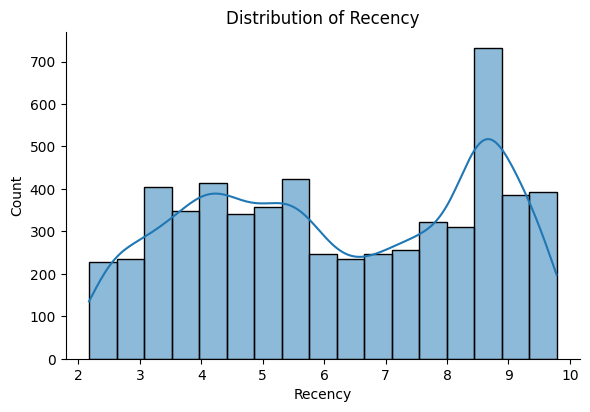

Frequency's: Skew: 0.0032395578360877864, : SkewtestResult(statistic=0.10152566886218183, pvalue=0.9191331820254567)


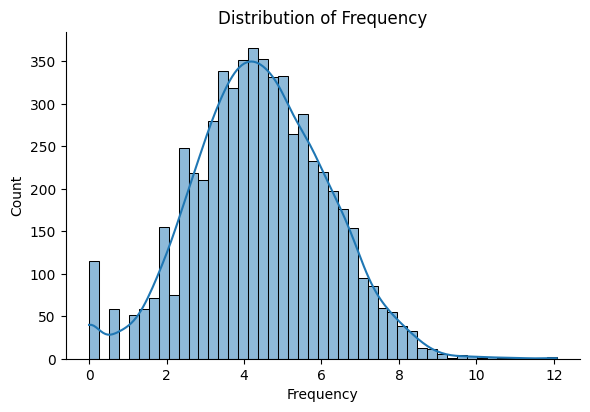

Monetary's: Skew: 0.020819893814243515, : SkewtestResult(statistic=0.6524134327556047, pvalue=0.5141345011224547)


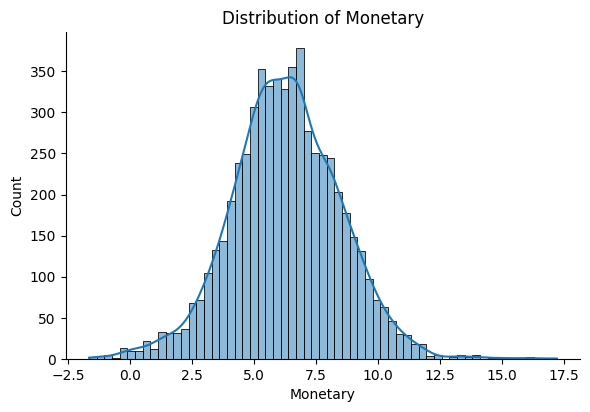

In [125]:
from rfm_segment import preprocess

df_rfm_log = df_rfm[['Recency', 'Frequency', 'Monetary']].copy(deep=True)

rfm_preprocess = preprocess.PreprocessKMeans(df_rfm_log)
df_rfm_log = rfm_preprocess.normalize_boxcox()
rfm_preprocess.check_skew_all()

### 4.2.1. Preprocess the Data

In [126]:
from rfm_segment import preprocess

df_rfm_scaled = preprocess.standardize(df_rfm_log)
df_rfm_scaled.head()

Recency  Frequency  Monetary
0  0.874071  -0.312931  0.144034
1 -1.659983   1.036884  0.853789
2 -0.230645  -0.031955  0.094551
3 -1.042685   0.858597  1.618249
4  0.834725  -0.780162 -0.623850

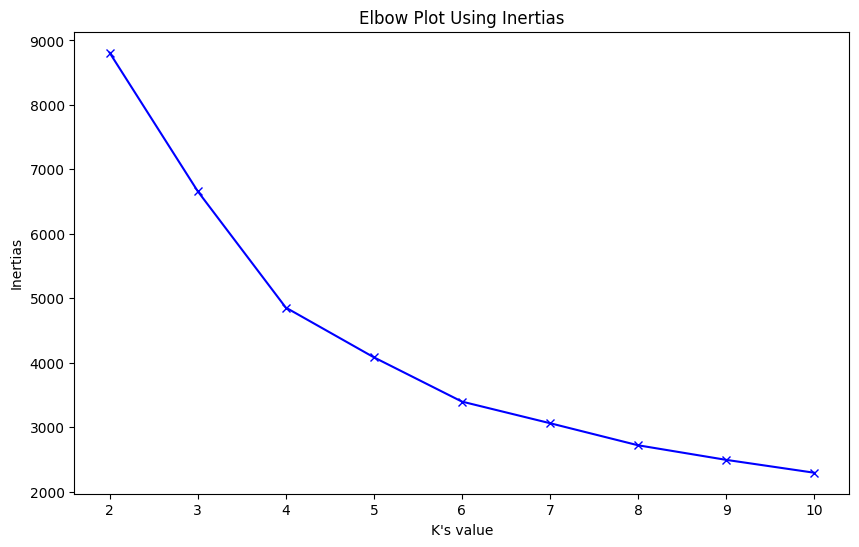

In [128]:
from rfm_segment import kmeans

kmeans_instance = kmeans.OptimizeClusters(df_rfm_scaled)
kmeans_instance.method_elbow(K_max=10)

For n_clusters = 2 The average silhouette_score is : 0.42158702469308384
For n_clusters = 3 The average silhouette_score is : 0.3335191587149673
For n_clusters = 4 The average silhouette_score is : 0.38041187544620525
For n_clusters = 5 The average silhouette_score is : 0.3603259889781616


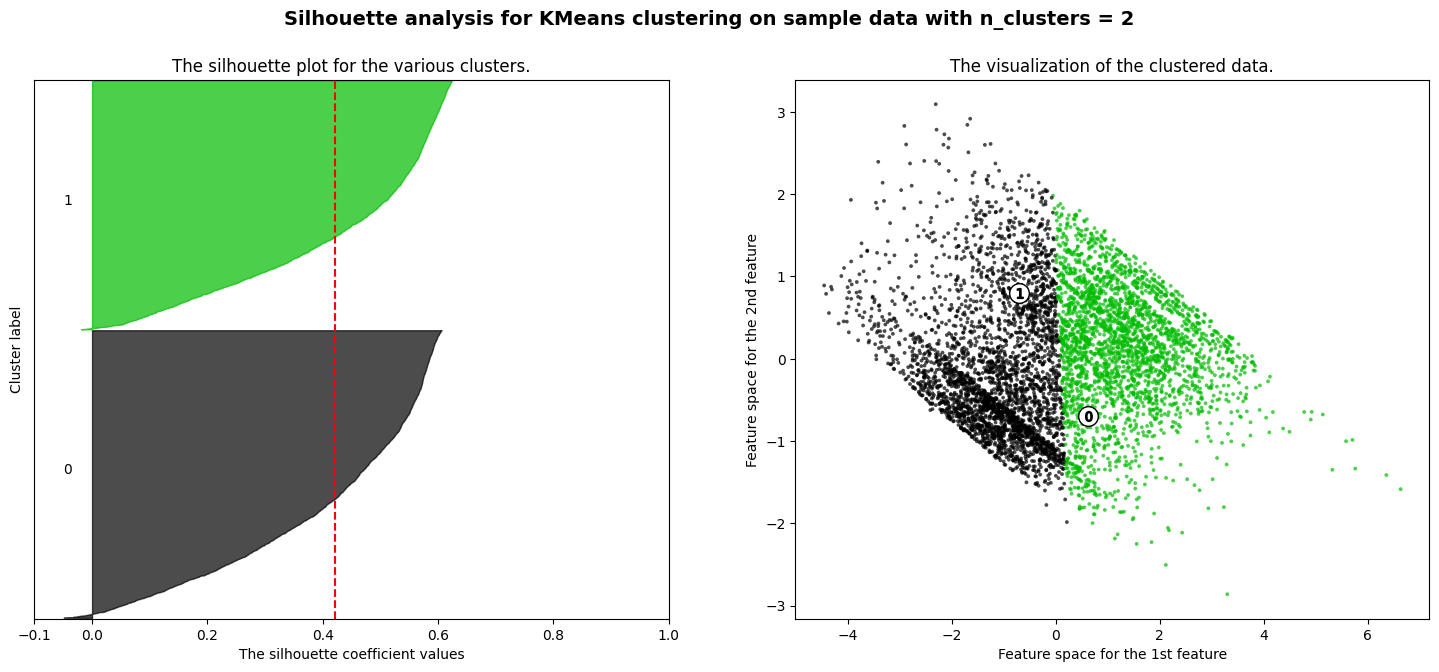

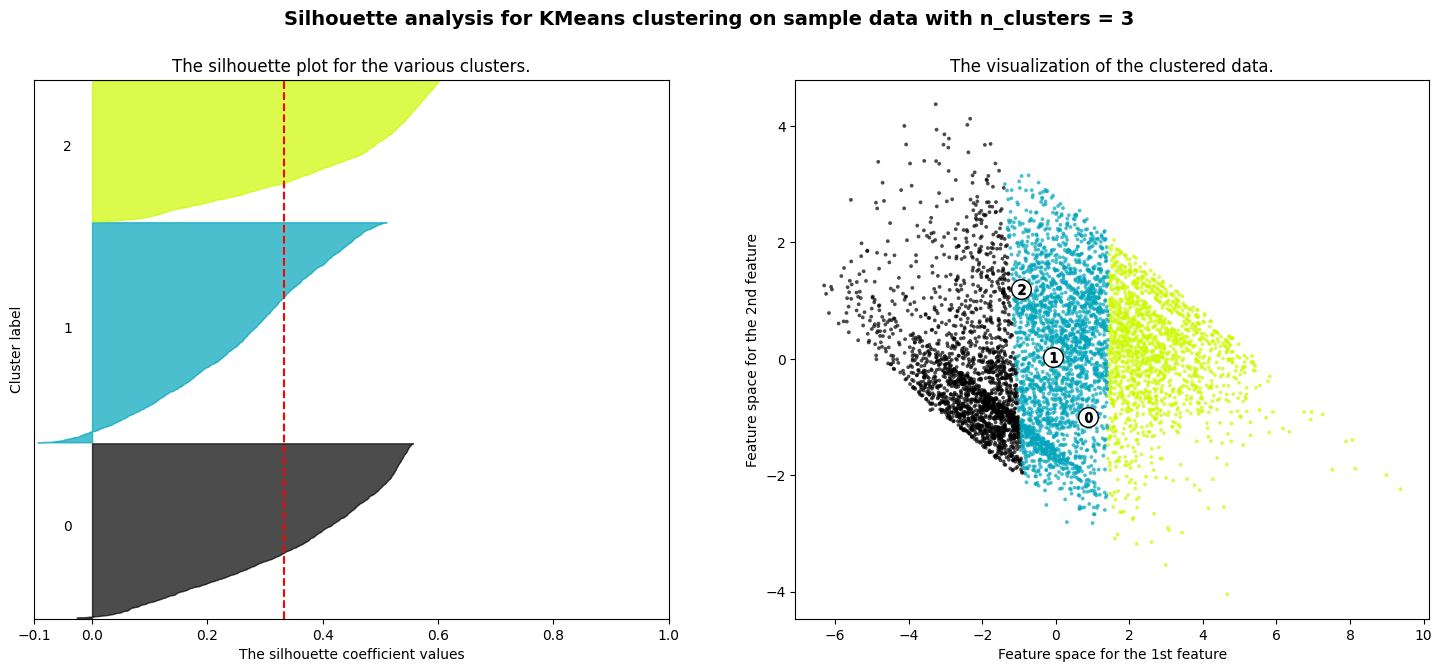

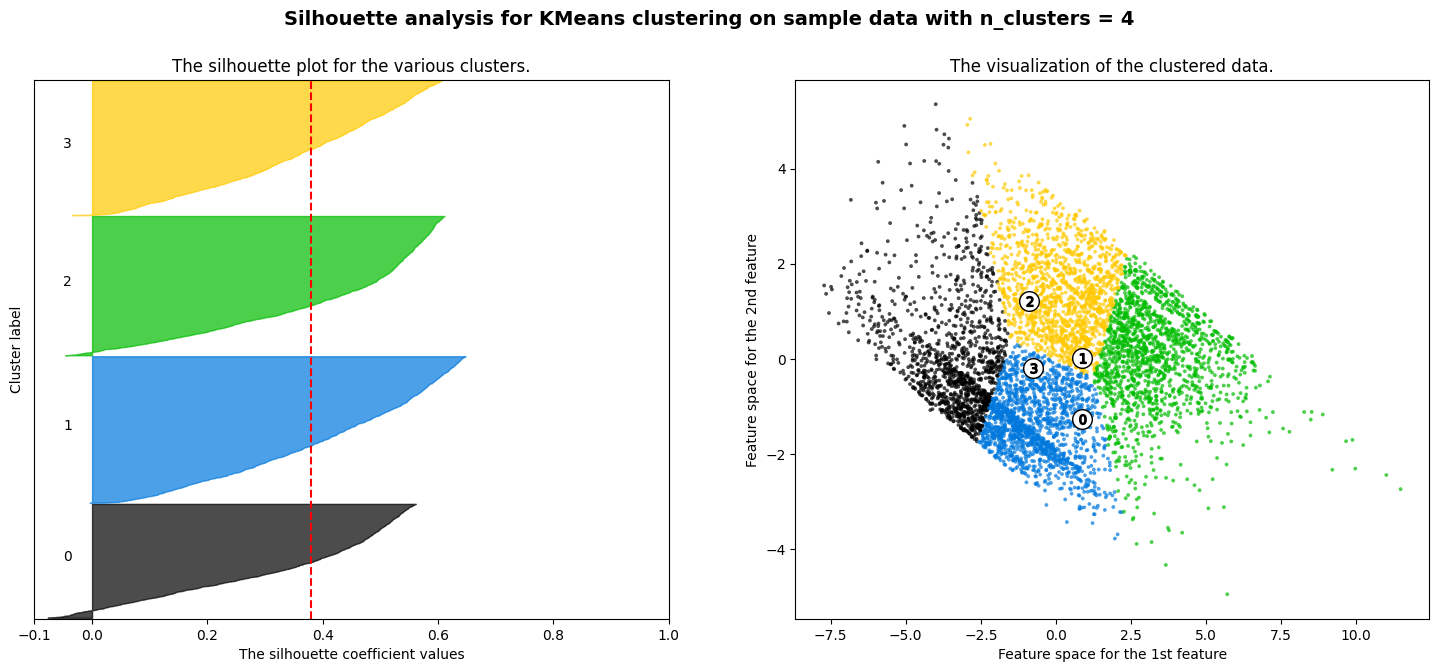

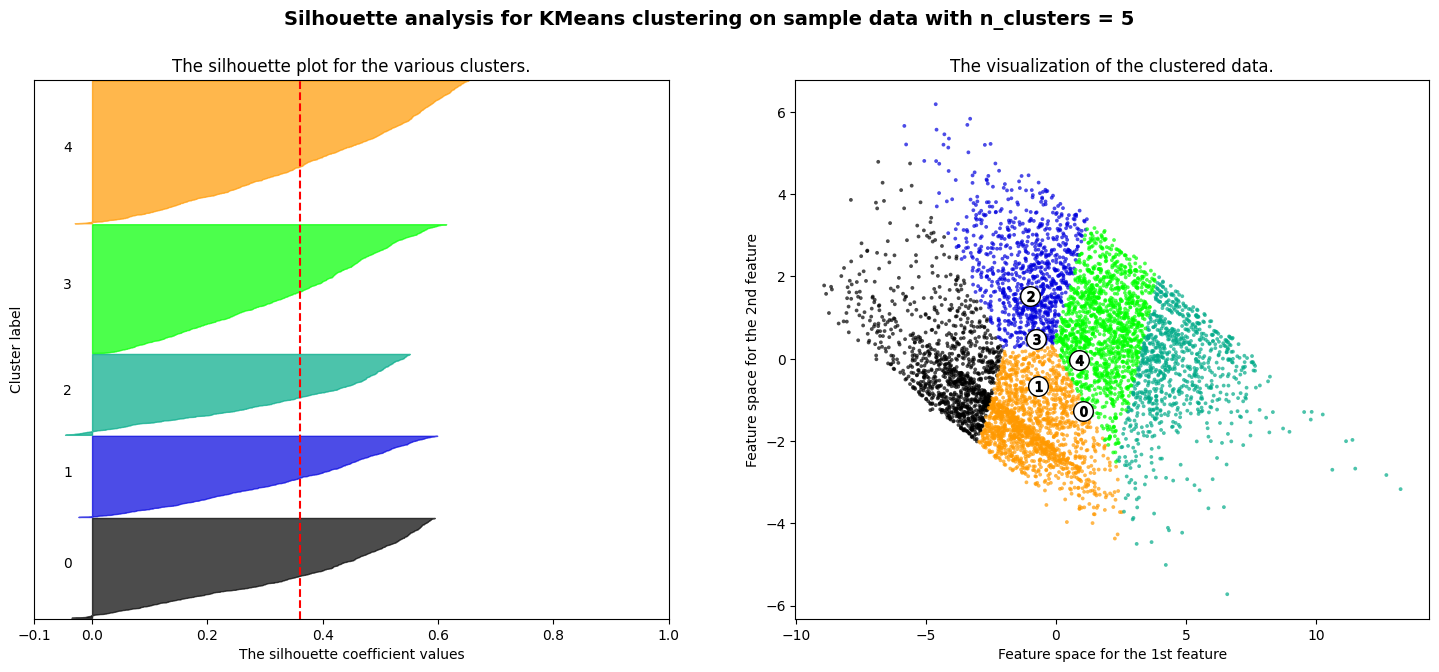

In [130]:
kmeans_instance.method_silhouette(K_max=5)

### 4.2.2. Fit and Evaluate the Clusters

In [328]:
# prepare all the dataframe for the fitevalute class

df_rfm_ori = df_rfm.reset_index()[['Customer ID', 'Recency', 'Frequency', 'Monetary']]
df_rfm_ori_wo_id = df_rfm[['Recency', 'Frequency', 'Monetary']].reset_index(drop=True)
df_rfm_scaled = df_rfm_scaled.drop(['Cluster', 'Customer ID'], axis=1)

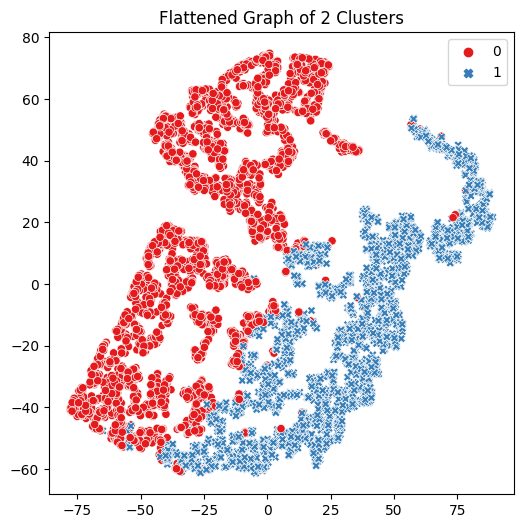

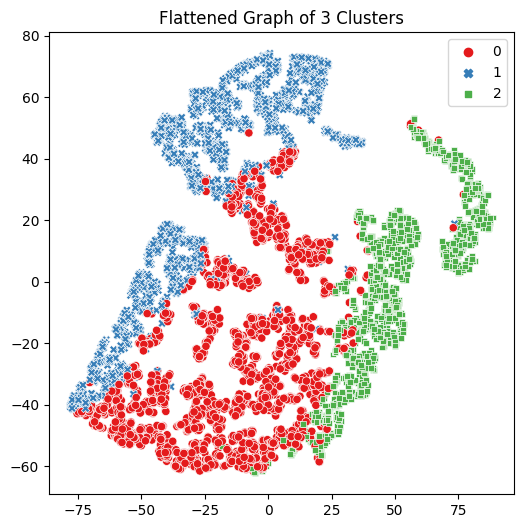

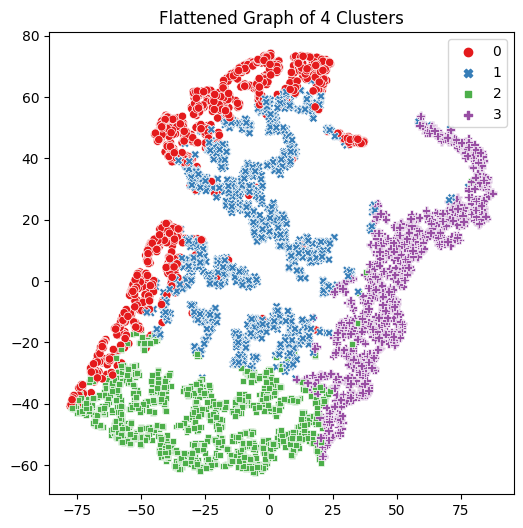

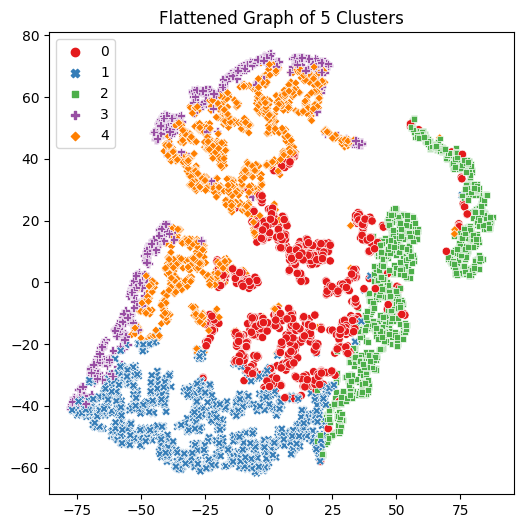

In [334]:
from rfm_segment import kmeans

kmeans_fitted = kmeans.FitEvaluate(df_rfm_ori=df_rfm_ori, 
                                   df_rfm_ori_wo_id=df_rfm_ori_wo_id, 
                                   df_rfm_scaled=df_rfm_scaled,
                                   K_max= 5)

kmeans_fitted.kmeans_plot_all()

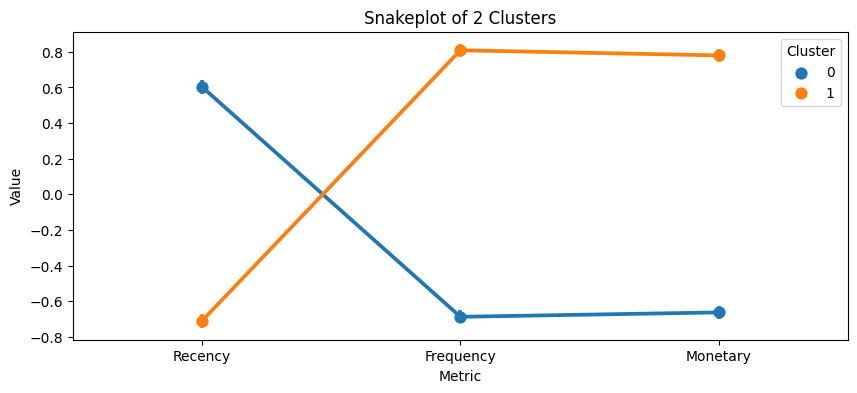

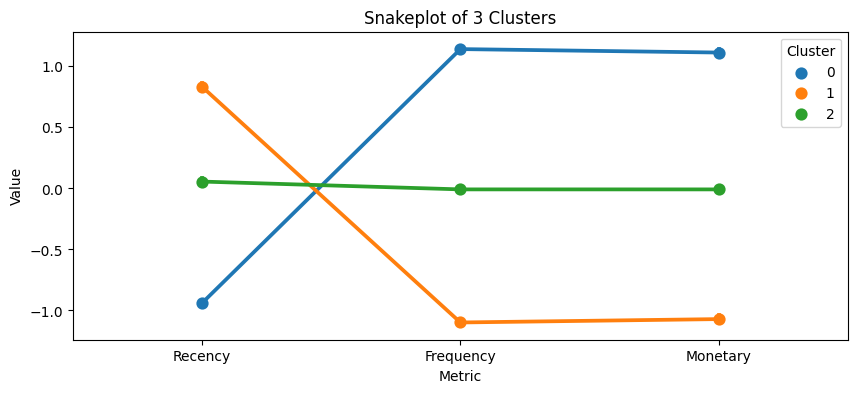

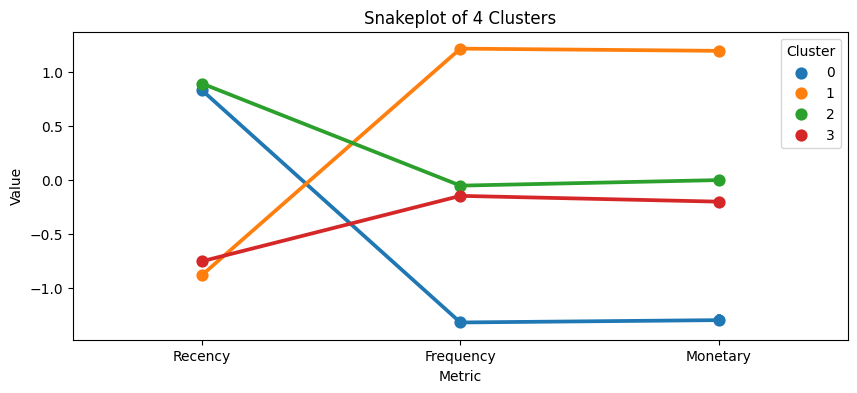

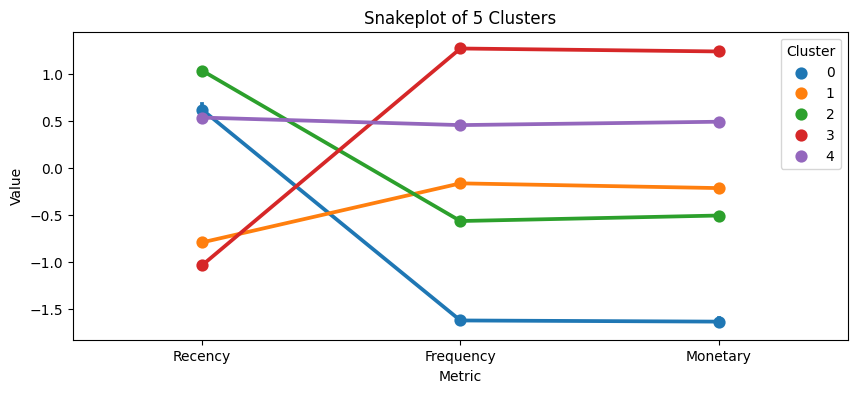

In [336]:
# fit the dataframe that contains clusters for all data
kmeans_fitted.kmeans_df_all()

# make a snake plot out of the dataframe with clusters
kmeans_fitted.snake_plot_all()